# Monte Carlo Method

As a simple example of a Monte Carlo method, we will approximate the value of $\pi$:

In [1]:
import numpy as np
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom
import loopy as lp

from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_2

In [3]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7fa2c133d6e8>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x2be2948>


Choice [0]: 


Set the environment variable PYOPENCL_CTX='' to avoid being asked again.


## Sample generation

In [34]:
knl = lp.make_kernel(
        "{ [i, j]: 0<=i<n and 0<=j < 2}",
        """
        <> ctr = make_uint4(0, 1, 2, 3)
        for i
            <> key2 = make_uint2(i, k1)
            <> rng_res, <> dummy = philox4x32_f32(ctr, key2)

            samples[i,0] = rng_res.s0 + 1j*rng_res.s1 {id=samp0}
            samples[i,1] = rng_res.s2 + 1j*rng_res.s3 {id=samp1}

            accepted[i,j] = real(samples[i,j] * conj(samples[i,j])) < 1 {dep=samp*,nosync=samp*}
        end
        """)                                                                     

knl = lp.split_iname(knl, "i", 128, outer_tag="g.0", inner_tag="l.0")
knl = lp.set_options(knl, return_dict=True)

In [35]:
print(knl)

---------------------------------------------------------------------------
KERNEL: loopy_kernel
---------------------------------------------------------------------------
ARGUMENTS:
accepted: type: <auto/runtime>, shape: (n, 2), dim_tags: (N1:stride:2, N0:stride:1) aspace: global
k1: ValueArg, type: <auto/runtime>
n: ValueArg, type: <auto/runtime>
samples: type: <auto/runtime>, shape: (n, 2), dim_tags: (N1:stride:2, N0:stride:1) aspace: global
---------------------------------------------------------------------------
DOMAINS:
[n] -> { [j, i_outer, i_inner] : 0 <= j <= 1 and i_inner >= 0 and -128i_outer <= i_inner <= 127 and i_inner < n - 128i_outer }
---------------------------------------------------------------------------
INAME IMPLEMENTATION TAGS:
i_inner: l.0
i_outer: g.0
j: None
---------------------------------------------------------------------------
TEMPORARIES:
ctr: type: <auto/runtime>, shape: () scope:auto
dummy: type: <auto/runtime>, shape: () scope:auto
key2: type: <a

In [36]:
knl = lp.set_options(knl, write_cl=True)

In [37]:
evt, result = knl(queue, n=100000, k1=np.int32(99123))

samples = result["samples"].reshape(-1)
accepted = result["accepted"].reshape(-1)

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif
#define PYOPENCL_DEFINE_CDOUBLE

#include <pyopencl-complex.h>
#include <pyopencl-random123/philox.cl>



typedef union {
    uint4 v;
    philox4x32_ctr_t c;
} philox4x32_ctr_vec_union;


uint4 philox4x32_bump(uint4 ctr)
{
    if (++ctr.x == 0)
        if (++ctr.y == 0)
            ++ctr.z;
    return ctr;
}

uint4 philox4x32_gen(
        uint4 ctr,
        uint2 key,
        uint4 *new_ctr)
{
    philox4x32_ctr_vec_union result;
    result.c = philox4x32(
        *(philox4x32_ctr_t *) &ctr,
        *(philox4x32_key_t *) &key);
    *new_ctr = philox4x32_bump(ctr);
    return result.v;
}

float4 philox4x32_f32(
        uint4 ctr,
        uint2 key,
        uint4 *new_ctr)
{
    *new_ctr = ctr;
    return
        convert_float4(philox4x32_gen(*new_ctr, key, new_ctr))
        * 2.3283064365386963e-10f;
}

double4 philox4x32_f64(


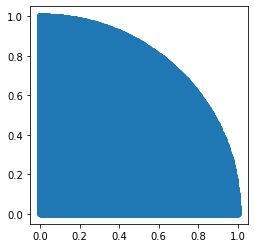

In [38]:
import matplotlib.pyplot as pt

samples_host = samples.get()
accepted_host = accepted.get() != 0

pt.gca().set_aspect("equal")
pt.plot(
    samples_host[accepted_host].real,
    samples_host[accepted_host].imag, "o")

Lastly, we compute the ratio of accepted to the total number of samples to get our approximate value of $\pi$:

In [39]:
4 * cl.array.sum(accepted).get() / len(samples)

3.14292

We (roughly) expect convergence as $1/\sqrt N$, so this gives an idea of the relative error to expect:

In [40]:
1/np.sqrt(len(samples))

0.00223606797749979

## Direct Reduction

In [56]:
knl = lp.make_kernel(
        "{ [l, g, j, isamp]: 0<=l<nl and 0<=g,j<ng and 0<=isamp< 2}",
        """
        <> ctr = make_uint4(0, 1, 2, 3)
        for g
            for l
                <> key2 = make_uint2(l + nl*g, 1234)
                <> rng_res, <> dummy = philox4x32_f32(ctr, key2)

                <> samples[0] = rng_res.s0 + 1j*rng_res.s1     {id=samp1}
                   samples[1] = rng_res.s2 + 1j*rng_res.s3     {id=samp2}

                <> accepted[isamp] = real(samples[isamp] * conj(samples[isamp])) < 1 \
                                                                {dep=samp1:samp2} 
            end
        
            <> tmp[g] = sum(l, accepted[0] + accepted[1]) 
        end
        ... gbarrier {id=barr,dep_query=writes:tmp}
        result = sum(j, tmp[j]) {id=finalred,dep=barr}
        """)                                                                     

size = 1000000
ng = 50

knl = lp.fix_parameters(knl, ng=ng)                                               

knl = lp.set_options(knl, write_cl=True, highlight_cl=True)                                          

ref_knl = knl                                                                     

knl = lp.split_iname(knl, "l", 128, inner_tag="l.0")
knl = lp.split_reduction_outward(knl, "l_inner")
knl = lp.tag_inames(knl, "g:g.0,j:l.0")
knl = lp.preprocess_kernel(knl)
knl = lp.add_dependency(knl, "id:finalred_j_init", "id:barr")
knl = lp.add_dependency(knl, "id:finalred_j_init_neutral", "id:barr")

evt, (result,) = knl(queue, nl=size) 

nsamples = size*2*ng
print(4*result.get()/nsamples, nsamples/1e9, "billion samples")

#define lid(N) ((int) get_local_id(N))
#define gid(N) ((int) get_group_id(N))
#if __OPENCL_C_VERSION__ < 120
#pragma OPENCL EXTENSION cl_khr_fp64: enable
#endif
#define PYOPENCL_DEFINE_CDOUBLE

#include <pyopencl-complex.h>
#include <pyopencl-random123/philox.cl>



typedef union {
    uint4 v;
    philox4x32_ctr_t c;
} philox4x32_ctr_vec_union;


uint4 philox4x32_bump(uint4 ctr)
{
    if (++ctr.x == 0)
        if (++ctr.y == 0)
            ++ctr.z;
    return ctr;
}

uint4 philox4x32_gen(
        uint4 ctr,
        uint2 key,
        uint4 *new_ctr)
{
    philox4x32_ctr_vec_union result;
    result.c = philox4x32(
        *(philox4x32_ctr_t *) &ctr,
        *(philox4x32_key_t *) &key);
    *new_ctr = philox4x32_bump(ctr);
    return result.v;
}

float4 philox4x32_f32(
        uint4 ctr,
        uint2 key,
        uint4 *new_ctr)
{
    *new_ctr = ctr;
    return
        convert_float4(philox4x32_gen(*new_ctr, key, new_ctr))
        * 2.3283064365386963e-10f;
}

double4 philox4x32_f64(
